This code does weighting of euclidean and addition to the cosine cost matrix.

In [1]:

import math
import numpy
import librosa
from enum import Enum
import struct

from scipy.spatial.distance import cdist

NUM_MFCC = 13
NUM_MELS = 40
SAMPLE_RATE = 16000
NUM_FFT = 2048
FFT_ORDER  = 512
LOWER_FREQ = 133.333300
HIGHEST_FREQ = 6855.497600
WINDOW_LENGTH = int(0.10 * SAMPLE_RATE)
HOP_LENGTH = int(0.04 * SAMPLE_RATE)
EMPHASIS_FACTOR = 0.97
DTW_MARGIN = 60

def normalize_matrix(matrix):
    max_val = numpy.max(matrix)
    return matrix / max_val

def get_sorted(unsorted):
    sorted = []
    idx_arr = []
    sorted.append(unsorted[0])
    idx_arr.append(0)
    for i in range(1, len(unsorted)):
        inserted = 0
        for j in range(0, len(sorted)):
            if (unsorted[i] < sorted[j]):
                sorted.insert(j, unsorted[i])
                idx_arr.insert(j, i)
                inserted = 1
                break
        if (inserted == 0):
            sorted.append(unsorted[i])
            idx_arr.append(i)
    return sorted, idx_arr

def get_sorted_segments(unsorted, key):
    sorted = []
    sorted.append(unsorted[0])
    for i in range(1, len(unsorted)):
        start, end = 0, len(sorted)-1
        while (start < end):
            mid = int((end - start) / 2) + start
            if (unsorted[i][key] < sorted[mid][key]):
                end = mid - 1
            else:
                start = mid + 1
        assert start >= 0
        assert end <= len(sorted)
        if (unsorted[i][key] > sorted[end][key]):
            if (end == len(sorted)):
                sorted.append(unsorted[i])
            else:        
                sorted.insert(end+1, unsorted[i])
        else:
            sorted.insert(end, unsorted[i])
    return sorted

def get_energy_level_idx(energy_val, 
                    energy_median,
                    energy_max,
                    num_energy_levels_bef_median,
                    num_energy_levels_after_median):

    energy_level_start = 0
    
    for i in range(0, num_energy_levels_bef_median + num_energy_levels_after_median):
        if (i < num_energy_levels_bef_median):
            energy_level_end = energy_level_start + (energy_median/num_energy_levels_bef_median)
        else:
            energy_level_end = energy_level_start + ((energy_max - energy_median)/num_energy_levels_after_median)

        if (energy_level_start <= energy_val <= energy_level_end):
            return i

        energy_level_start = energy_level_end

    print("should not be here: start %.2f end %.2f val %.2f" %(energy_level_start, energy_level_end, energy_val))
    return i

def get_deviation_bkts_with_energy_levels(segments_sorted_array,
                        deviation_median, deviation_max,
                        energy_median, energy_max,
                        num_bkts_bef_median, 
                        num_bkts_after_median, 
                        num_energy_levels_bef_median,
                        num_energy_levels_after_median):

    bkt_arr = []
    start = segments_sorted_array[0]["deviation"]
    for i in range(0, num_bkts_bef_median + num_bkts_after_median):
        bkt = []
        energy_count_arr = numpy.zeros(num_energy_levels_bef_median + num_energy_levels_after_median + 1)
        if (i < num_bkts_bef_median):
            bkt_val = deviation_median/num_bkts_bef_median
        else:
            bkt_val = (deviation_max - deviation_median)/num_bkts_after_median
        
        end = start + bkt_val        
        bkt_arr.append({"bkt":bkt, "energy_count_arr":energy_count_arr,"start":start, "end":end})
        start = end

    curr_bkt = 0
    for i in range(0, len(segments_sorted_array)):
        assert segments_sorted_array[i]["deviation"] >= bkt_arr[curr_bkt]["start"]
        if (segments_sorted_array[i]["deviation"] > bkt_arr[curr_bkt]["end"]):
            curr_bkt += 1
        bkt_arr[curr_bkt]["bkt"].append(segments_sorted_array[i])
        bkt_arr[curr_bkt]["energy_count_arr"][0] += 1

        energy = segments_sorted_array[i]["energy"]
        energy_level_idx = get_energy_level_idx(energy, 
                                        energy_median, energy_max,
                                        num_energy_levels_bef_median,
                                        num_energy_levels_after_median)
        #inc the idx by 1. 0th elem is the total count
        bkt_arr[curr_bkt]["energy_count_arr"][energy_level_idx+1] += 1
    
    return bkt_arr

class AlignmentAlgorithm(Enum):
    DTW_STRIPE = "DTW_STRIPE"
    DTW_EXACT = "DTW_EXACT"

DTW_ALGORITHM = AlignmentAlgorithm.DTW_EXACT


"""
This module contains the implementation
of dynamic time warping (DTW) algorithms
to align two audio waves, represented by their
Mel-frequency cepstral coefficients (MFCCs).

This module contains the following classes:

* :class:`~aeneas.dtw.DTWAlgorithm`,
  an enumeration of the available algorithms;
* :class:`~aeneas.dtw.DTWAligner`,
  the actual wave aligner;
* :class:`~aeneas.dtw.DTWExact`,
  a DTW aligner implementing the exact (full) DTW algorithm;
* :class:`~aeneas.dtw.DTWStripe`,
  a DTW aligner implementing the Sachoe-Chiba band heuristic.

To align two wave files:

1. build an :class:`~aeneas.dtw.DTWAligner` object,
   passing in the constructor
   the paths of the two wave files
   or their MFCC representations;
2. call :func:`~aeneas.dtw.DTWAligner.compute_path`
   to compute the min cost path between
   the MFCC representations of the two wave files.

.. warning:: This module might be refactored in a future version
"""

class aeneas_dtw():

    def __init__(
        self,
        ap, q_audio, r_audio
    ):
        self.ap = ap
        self.params = ap.params
        self.query_audio = q_audio 
        self.ref_audio = r_audio
        self._setup_dtw()
                
    def compute_cost_matrix(self):
        """
        Compute the accumulated cost matrix, and return it.

        Return ``None`` if the accumulated cost matrix cannot be computed
        because one of the two waves is empty after masking (if requested).

        :rtype: :class:`numpy.ndarray` (2D)
        :raises: RuntimeError: if both the C extension and
                               the pure Python code did not succeed.

        .. versionadded:: 1.2.0
        """
        if self.dtw is None:
            assert 0
        return self.dtw.compute_cost_matrix()

    def compute_accumulated_cost_matrix(self):
        """
        Compute the accumulated cost matrix, and return it.

        Return ``None`` if the accumulated cost matrix cannot be computed
        because one of the two waves is empty after masking (if requested).

        :rtype: :class:`numpy.ndarray` (2D)
        :raises: RuntimeError: if both the C extension and
                               the pure Python code did not succeed.

        .. versionadded:: 1.2.0
        """
        if self.dtw is None:
            assert 0
        return self.dtw.compute_accumulated_cost_matrix()

    def compute_path(self):
        """
        Compute the min cost path between the two waves, and return it.

        Return the computed path as a tuple with two elements,
        each being a :class:`numpy.ndarray` (1D) of ``int`` indices: ::

        ([r_1, r_2, ..., r_k], [s_1, s_2, ..., s_k])

        where ``r_i`` are the indices in the real wave
        and ``s_i`` are the indices in the synthesized wave,
        and ``k`` is the length of the min cost path.

        Return ``None`` if the accumulated cost matrix cannot be computed
        because one of the two waves is empty after masking (if requested).

        :rtype: tuple (see above)
        :raises: RuntimeError: if both the C extension and
                               the pure Python code did not succeed.
        """
        return self.dtw.compute_path()

    def _setup_dtw(self):
        """
        Set the DTW object up.
        """

        # setup
        window_shift = self.params.hop_length/self.params.sr
        delta = int(2 * self.params.dtw_margin / window_shift)
        
        # set the selected algorithm
        if self.params.dtw_algorithm == AlignmentAlgorithm.DTW_EXACT:
            self.dtw = DTWExact(self.ap,
                self.query_audio.mfcc,
                self.ref_audio.mfcc                
            )
        else:
            self.dtw = DTWStripe(self.ap,
                self.query_audio.mfcc,
                self.ref_audio.mfcc,
                delta
            )

class DTWStripe():

    def __init__(self, ap, m1, m2, delta):
        self.m1 = m1
        self.m2 = m2
        self.delta = delta
        self.ap = ap

    def compute_cost_matrix(self):
        if (self.ap.weight != -1):
            return self._compute_cost_matrix_wegihted()
        return self._compute_cost_matrix()

    def compute_accumulated_cost_matrix(self):
        cost_matrix = self._compute_cost_matrix()
        accumulated_cost_matrix = self._compute_accumulated_cost_matrix(cost_matrix)
        return accumulated_cost_matrix

    def compute_path(self):
        try:
            cost_matrix, centers = self.compute_cost_matrix()
            accumulated_cost_matrix = self._compute_accumulated_cost_matrix(cost_matrix, centers)
            best_path = self._compute_best_path(accumulated_cost_matrix, centers)
            return best_path
        except Exception as exc:
            print("An unexpected error occurred while running pure Python code", exc, False, None)
        return (False, None)

    def _compute_cost_matrix_wegihted(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :]
        mfcc2 = self.m2[1:, :]
        norm2_1 = numpy.sqrt(numpy.sum(mfcc1 ** 2, 0))
        norm2_2 = numpy.sqrt(numpy.sum(mfcc2 ** 2, 0))
    
        print(self.ap.weight)        
        
        n = mfcc1.shape[1]
        m = mfcc2.shape[1]
        delta = self.delta
        if delta > m:
            delta = m
    
        cost_matrix = numpy.zeros((n, delta))
        cosine_matrix = numpy.zeros((n, delta))
        euc_matrix = numpy.zeros((n, delta))
        centers = numpy.zeros(n, dtype=int)
    
        for i in range(n):
            # center j at row i
            center_j = (m * i) // n
            # COMMENTED self.log([u"Center at row %d is %d", i, center_j])
            range_start = max(0, center_j - (delta // 2))
            range_end = range_start + delta
            if range_end > m:
                range_end = m
                range_start = range_end - delta
            centers[i] = range_start
            # COMMENTED self.log([u"Range at row %d is %d %d", i, range_start, range_end])
            for j in range(range_start, range_end):
                diff = mfcc1[:, i] - mfcc2[:, j]
                euclidean_dist = numpy.sqrt(numpy.sum(diff ** 2))

                tmp = mfcc1[:, i].transpose().dot(mfcc2[:, j])
                tmp /= norm2_1[i] * norm2_2[j]
                cosine_dist = 1 - tmp
        
                cosine_matrix[i][j - range_start] = cosine_dist
                euc_matrix[i][j - range_start] = euclidean_dist

        euc_matrix = normalize_matrix(euc_matrix)
        cosine_matrix = normalize_matrix(cosine_matrix)                
        
        for i in range(len(euc_matrix)):
            for j in range(len(euc_matrix[i])):
                cost_matrix[i][j] = \
                    cosine_matrix[i][j] \
                    + (self.ap.weight * euc_matrix[i][j])
                
        return (cost_matrix, centers)

    def _compute_cost_matrix(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :]
        mfcc2 = self.m2[1:, :]
        norm2_1 = numpy.sqrt(numpy.sum(mfcc1 ** 2, 0))
        norm2_2 = numpy.sqrt(numpy.sum(mfcc2 ** 2, 0))
        n = mfcc1.shape[1]
        m = mfcc2.shape[1]
        delta = self.delta
        if delta > m:
            delta = m
        cost_matrix = numpy.zeros((n, delta))
        centers = numpy.zeros(n, dtype=int)
        for i in range(n):
            # center j at row i
            center_j = (m * i) // n
            # COMMENTED self.log([u"Center at row %d is %d", i, center_j])
            range_start = max(0, center_j - (delta // 2))
            range_end = range_start + delta
            if range_end > m:
                range_end = m
                range_start = range_end - delta
            centers[i] = range_start
            # COMMENTED self.log([u"Range at row %d is %d %d", i, range_start, range_end])
            for j in range(range_start, range_end):
                tmp = mfcc1[:, i].transpose().dot(mfcc2[:, j])
                tmp /= norm2_1[i] * norm2_2[j]
                cost_matrix[i][j - range_start] = 1 - tmp
        return (cost_matrix, centers)

    def _compute_accumulated_cost_matrix(self, cost_matrix, centers):
        # create accumulated cost matrix
        #
        # a[i][j] = c[i][j] + min(c[i-1][j-1], c[i-1][j], c[i][j-1])
        #
        return self._compute_acm_in_place(cost_matrix, centers)

    def _compute_acm_in_place(self, cost_matrix, centers):
        n, delta = cost_matrix.shape
        current_row = numpy.copy(cost_matrix[0, :])
        # COMMENTED cost_matrix[0][0] = current_row[0]
        for j in range(1, delta):
            cost_matrix[0][j] = current_row[j] + cost_matrix[0][j - 1]
        # fill table
        for i in range(1, n):
            current_row = numpy.copy(cost_matrix[i, :])
            offset = centers[i] - centers[i - 1]
            for j in range(delta):
                cost0 = numpy.inf
                if (j + offset) < delta:
                    cost0 = cost_matrix[i - 1][j + offset]
                cost1 = numpy.inf
                if j > 0:
                    cost1 = cost_matrix[i][j - 1]
                cost2 = numpy.inf
                if ((j + offset - 1) < delta) and ((j + offset - 1) >= 0):
                    cost2 = cost_matrix[i - 1][j + offset - 1]
                cost_matrix[i][j] = current_row[j] + min(cost0, cost1, cost2)
        return cost_matrix

    def _compute_best_path(self, acc_matrix, centers):
        # get dimensions
        n, delta = acc_matrix.shape
        i = n - 1
        j = delta - 1 + centers[i]
        path = [(i, j)]
        # compute best (min cost) path
        while (i > 0) or (j > 0):
            if i == 0:
                path.append((0, j - 1))
                j -= 1
            elif j == 0:
                path.append((i - 1, 0))
                i -= 1
            else:
                offset = centers[i] - centers[i - 1]
                r_j = j - centers[i]
                cost0 = numpy.inf
                if (r_j + offset) < delta:
                    cost0 = acc_matrix[i - 1][r_j + offset]
                cost1 = numpy.inf
                if r_j > 0:
                    cost1 = acc_matrix[i][r_j - 1]
                cost2 = numpy.inf
                if (r_j > 0) and ((r_j + offset - 1) < delta) and ((r_j + offset - 1) >= 0):
                    cost2 = acc_matrix[i - 1][r_j + offset - 1]
                costs = [
                    cost0,
                    cost1,
                    cost2
                ]
                moves = [
                    (i - 1, j),
                    (i, j - 1),
                    (i - 1, j - 1)
                ]
                min_cost = numpy.argmin(costs)
                # COMMENTED self.log([u"Selected min cost move %d", min_cost])
                min_move = moves[min_cost]
                path.append(min_move)
                i, j = min_move
        return path

class DTWExact():

    def __init__(self, ap, m1, m2):
        self.m1 = m1
        self.m2 = m2
        self.ap = ap

    def compute_cost_matrix(self):
        return self._compute_cost_matrix()

    def compute_accumulated_cost_matrix(self):
        ap = self.ap
        if hasattr(ap, 'cost_matrix'):
            cost_matrix = ap.cost_matrix
        else:
            cost_matrix = self._compute_cost_matrix()

        return self._compute_accumulated_cost_matrix(cost_matrix)

    def compute_path(self):
        accumulated_cost_matrix = self.compute_accumulated_cost_matrix()
        best_path = self._compute_best_path(accumulated_cost_matrix)
        return best_path

    def _compute_cost_matrix_euc(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :].T
        mfcc2 = self.m2[1:, :].T
        
        return cdist(mfcc1, mfcc2)
        
        cost_matrix = numpy.zeros((mfcc1.shape[0], mfcc2.shape[0]))
        for i in range(0, mfcc1.shape[0]):
            for j in range(0, mfcc2.shape[0]):
                cost_matrix[i][j] = numpy.linalg.norm(mfcc1[i] - mfcc2[j])
        return cost_matrix

    def _compute_cost_matrix(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :]
        mfcc2 = self.m2[1:, :]
        norm2_1 = numpy.sqrt(numpy.sum(mfcc1 ** 2, 0))
        norm2_2 = numpy.sqrt(numpy.sum(mfcc2 ** 2, 0))
        # compute dot product
        cost_matrix = mfcc1.transpose().dot(mfcc2)
        # normalize
        norm_matrix = numpy.outer(norm2_1, norm2_2)
        cost_matrix = 1 - (cost_matrix / norm_matrix)
        return cost_matrix

    def _compute_accumulated_cost_matrix(self, cost_matrix):
        # create accumulated cost matrix
        #
        # a[i][j] = c[i][j] + min(c[i-1][j-1], c[i-1][j], c[i][j-1])
        #
        return self._compute_acm_in_place(cost_matrix)

    def _compute_acm_in_place(self, cost_matrix):
        n, m = cost_matrix.shape
        current_row = numpy.copy(cost_matrix[0, :])
        # COMMENTED cost_matrix[0][0] = current_row[0]
        for j in range(1, m):
            cost_matrix[0][j] = current_row[j] + cost_matrix[0][j - 1]
        for i in range(1, n):
            current_row = numpy.copy(cost_matrix[i, :])
            cost_matrix[i][0] = cost_matrix[i - 1][0] + current_row[0]
            for j in range(1, m):
                cost_matrix[i][j] = current_row[j] + min(
                    cost_matrix[i - 1][j],
                    cost_matrix[i][j - 1],
                    cost_matrix[i - 1][j - 1]
                )
        return cost_matrix

    def _compute_best_path(self, acc_matrix):
        # get dimensions
        n, m = acc_matrix.shape
        i = n - 1
        j = m - 1
        path = [(i, j)]
        # compute best (min cost) path
        while (i > 0) or (j > 0):
            if i == 0:
                path.append((0, j - 1))
                j -= 1
            elif j == 0:
                path.append((i - 1, 0))
                i -= 1
            else:
                costs = [
                    acc_matrix[i - 1][j],
                    acc_matrix[i][j - 1],
                    acc_matrix[i - 1][j - 1]
                ]
                moves = [
                    (i - 1, j),
                    (i, j - 1),
                    (i - 1, j - 1)
                ]
                min_cost = numpy.argmin(costs)
                # COMMENTED self.log([u"Selected min cost move %d", min_cost])
                min_move = moves[min_cost]
                path.append(min_move)
                i, j = min_move
        return path

class aeneas_mfcc():
    """
    A class for computing Mel-frequency cepstral coefficients (MFCCs).
    """

    CUTOFF = 0.00001
    """ Cut-off threshold """

    MEL_10 = 2595.0
    """ Base Mel frequency """

    TAG = u"MFCC"

    def __init__(self, params):

        # store parameters in local attributes
        self.filter_bank_size = params.n_mel
        self.mfcc_size = params.n_mfcc
        self.fft_order = params.fft_order
        self.lower_frequency = params.low_freq
        self.upper_frequency = params.high_freq
        self.emphasis_factor = params.emphasis_factor
        self.window_length = params.win_length/params.sr
        self.window_shift = params.hop_length/params.sr

        # initialize DCT matrix
        self._create_dct_matrix()

        # initialized later by compute_from_data()
        self.data = None
        self.sample_rate = None
        self.filters = None
        self.hamming_window = None

    @classmethod
    def _hz2mel(cls, frequency):
        """
        Convert the given frequency in Hz to the Mel scale.

        :param float frequency: the Hz frequency to convert
        :rtype: float
        """
        return cls.MEL_10 * math.log10(1.0 + (frequency / 700.0))

    @classmethod
    def _mel2hz(cls, mel):
        """
        Convert the given Mel value to Hz frequency.

        :param float mel: the Mel value to convert
        :rtype: float
        """
        return 700.0 * (10 ** (mel / cls.MEL_10) - 1)

    def _create_dct_matrix(self):
        """
        Create the not-quite-DCT matrix as used by Sphinx,
        and store it in ```self.s2dct```.
        """
        self.s2dct = numpy.zeros((self.mfcc_size, self.filter_bank_size))
        for i in range(0, self.mfcc_size):
            freq = numpy.pi * float(i) / self.filter_bank_size
            self.s2dct[i] = numpy.cos(freq * numpy.arange(0.5, 0.5 + self.filter_bank_size, 1.0, 'float64'))
        self.s2dct[:, 0] *= 0.5
        self.s2dct = self.s2dct.transpose()

    def _create_mel_filter_bank(self):
        """
        Create the Mel filter bank,
        and store it in ``self.filters``.

        Note that it is a function of the audio sample rate,
        so it cannot be created in the class initializer,
        but only later in :func:`aeneas.mfcc.MFCC.compute_from_data`.
        """
        self.filters = numpy.zeros((1 + (self.fft_order // 2), self.filter_bank_size), 'd')
        dfreq = float(self.sample_rate) / self.fft_order
        nyquist_frequency = self.sample_rate / 2
        if self.upper_frequency > nyquist_frequency:
            self.log_exc(u"Upper frequency %f exceeds Nyquist frequency %f" % (self.upper_frequency, nyquist_frequency), None, True, ValueError)
        melmax = aeneas_mfcc._hz2mel(self.upper_frequency)
        melmin = aeneas_mfcc._hz2mel(self.lower_frequency)
        dmelbw = (melmax - melmin) / (self.filter_bank_size + 1)
        filt_edge = aeneas_mfcc._mel2hz(melmin + dmelbw * numpy.arange(self.filter_bank_size + 2, dtype='d'))

        # TODO can this code be written more numpy-style?
        #      (the performance loss is negligible, it is just ugly to see)
        for whichfilt in range(0, self.filter_bank_size):
            # int() casts to native int instead of working with numpy.float64
            leftfr = int(round(filt_edge[whichfilt] / dfreq))
            centerfr = int(round(filt_edge[whichfilt + 1] / dfreq))
            rightfr = int(round(filt_edge[whichfilt + 2] / dfreq))
            fwidth = (rightfr - leftfr) * dfreq
            height = 2.0 / fwidth
            if centerfr != leftfr:
                leftslope = height / (centerfr - leftfr)
            else:
                leftslope = 0
            freq = leftfr + 1
            while freq < centerfr:
                self.filters[freq, whichfilt] = (freq - leftfr) * leftslope
                freq = freq + 1
            # the next if should always be true!
            if freq == centerfr:
                self.filters[freq, whichfilt] = height
                freq = freq + 1
            if centerfr != rightfr:
                rightslope = height / (centerfr - rightfr)
            while freq < rightfr:
                self.filters[freq, whichfilt] = (freq - rightfr) * rightslope
                freq = freq + 1

    def _pre_emphasis(self):
        """
        Pre-emphasize the entire signal at once by self.emphasis_factor,
        overwriting ``self.data``.
        """
        self.data = numpy.append(self.data[0], self.data[1:] - self.emphasis_factor * self.data[:-1])

    def compute_from_data(self, data, sample_rate):
        """
        Compute MFCCs for the given audio data.

        The audio data must be a 1D :class:`numpy.ndarray`,
        that is, it must represent a monoaural (single channel)
        array of ``float64`` values in ``[-1.0, 1.0]``.

        :param data: the audio data
        :type  data: :class:`numpy.ndarray` (1D)
        :param int sample_rate: the sample rate of the audio data, in samples/s (Hz)
        :raises: ValueError: if the data is not a 1D :class:`numpy.ndarray` (i.e., not mono),
                             or if the data is empty
        :raises: ValueError: if the upper frequency defined in the ``rconf`` is
                             larger than the Nyquist frequenct (i.e., half of ``sample_rate``)
        """
        def _process_frame(self, frame):
            """
            Process each frame, returning the log(power()) of it.
            """
            # apply Hamming window
            frame *= self.hamming_window
            # compute RFFT
            fft = numpy.fft.rfft(frame, self.fft_order)
            # equivalent to power = fft.real * fft.real + fft.imag * fft.imag
            power = numpy.square(numpy.absolute(fft))
            #
            # return the log(power()) of the transformed vector
            # v1
            # COMMENTED logspec = numpy.log(numpy.dot(power, self.filters).clip(self.CUTOFF, numpy.inf))
            # COMMENTED return numpy.dot(logspec, self.s2dct) / self.filter_bank_size
            # v2
            return numpy.log(numpy.dot(power, self.filters).clip(self.CUTOFF, numpy.inf))

        if len(data.shape) != 1:
            self.log_exc(u"The audio data must be a 1D numpy array (mono).", None, True, ValueError)
        if len(data) < 1:
            self.log_exc(u"The audio data must not be empty.", None, True, ValueError)

        self.data = data
        self.sample_rate = sample_rate

        # number of samples in the audio
        data_length = len(self.data)

        # frame length in number of samples
        frame_length = int(self.window_length * self.sample_rate)

        # frame length must be at least equal to the FFT order
        frame_length_padded = max(frame_length, self.fft_order)

        # frame shift in number of samples
        frame_shift = int(self.window_shift * self.sample_rate)

        # number of MFCC vectors (one for each frame)
        # this number includes the last shift,
        # where the data will be padded with zeros
        # if the remaining samples are less than frame_length_padded
        number_of_frames = int((1.0 * data_length) / frame_shift)

        # create Hamming window
        self.hamming_window = numpy.hamming(frame_length_padded)

        # build Mel filter bank
        self._create_mel_filter_bank()

        # pre-emphasize the entire audio data
        self._pre_emphasis()

        # allocate the MFCCs matrix
        # v1
        # COMMENTED mfcc = numpy.zeros((number_of_frames, self.mfcc_size), 'float64')
        # v2
        mfcc = numpy.zeros((number_of_frames, self.filter_bank_size), 'float64')

        # compute MFCCs one frame at a time
        for frame_index in range(number_of_frames):
            # COMMENTED print("Computing frame %d / %d" % (frame_index, number_of_frames))

            # get the start and end indices for this frame,
            # do not overrun the data length
            frame_start = frame_index * frame_shift
            frame_end = min(frame_start + frame_length_padded, data_length)

            # frame is zero-padded if the remaining samples
            # are less than its length
            frame = numpy.zeros(frame_length_padded)
            frame[0:(frame_end - frame_start)] = self.data[frame_start:frame_end]

            # process the frame
            mfcc[frame_index] = _process_frame(self, frame)

        # v1
        # COMMENTED return mfcc
        # v2
        # return the dot product with the DCT matrix
        return numpy.dot(mfcc, self.s2dct) / self.filter_bank_size


def mfccs_to_secs(params, val):
    return val * params.hop_length / params.sr

def secs_to_mfccs(params, val):
    return int(val * params.sr / params.hop_length)
    
class AlignmentPair:

    def __init__(self, params, q_audio, r_audio, metric, weight):

        self.params = params
        self.query_audio = q_audio
        self.ref_audio = r_audio
        self.weight = weight
        
        assert metric == "euclidean" or metric == "cosine"
        self.metric = metric
        
        assert len(q_audio.labels) == len(r_audio.labels)
                    
    def get_segment_deviation(self, query_audio, 
                                 aligned_indices, 
                                 aligned_indices_mfcc):
    
        params = self.params
        query_labels = query_audio.labels
        
        assert len(query_labels) == len(aligned_indices)
        
        seg_end_deviation = numpy.zeros(len(query_labels))
        seg_energy_deviation = numpy.zeros(len(query_labels))
        
        if hasattr(query_audio, 'audio'):
            total_energy = numpy.sum(query_audio.audio**2)
        else:
            total_energy = 0
                        
        for i in range(0, len(query_labels)):
            exp_end = query_labels[i]["end"]
            act_end = aligned_indices[i]["end"]
                        
            end_diff = abs(exp_end - act_end)
    
            start_sample = int(min(exp_end, act_end) * params.sr)
            end_sample = int(max(exp_end, act_end) * params.sr)
            
            if end_diff and hasattr(query_audio, 'audio'):
                y = query_audio.audio[start_sample:end_sample]   
                energy = numpy.sum(y**2) / total_energy / end_diff
            else:
                energy = 0
            
            seg_end_deviation[i] = end_diff
            seg_energy_deviation[i] = energy
            
        return seg_end_deviation, seg_energy_deviation
        
    def _calc_alignment_deviation(self, query_audio, 
                                 aligned_indices, 
                                 aligned_indices_mfcc):
    
        params = self.params
        query_labels = query_audio.labels
        end_diff_arr = []
        energy_diff_arr = []
        total_end_diff, total_energy_diff = 0,0
        
        assert len(query_labels) == len(aligned_indices)
        
        if hasattr(query_audio, 'audio'):
            total_energy = numpy.sum(query_audio.audio**2)
        else:
            total_energy = 0
            
        for i in range(0, len(query_labels)):
            exp_end = query_labels[i]["end"]
            act_end = aligned_indices[i]["end"]
                        
            end_diff = abs(exp_end - act_end)
            total_end_diff += end_diff
    
            start_sample = int(min(exp_end, act_end) * params.sr)
            end_sample = int(max(exp_end, act_end) * params.sr)

            if hasattr(query_audio, 'audio'):
                y = query_audio.audio[start_sample:end_sample]   
                energy = numpy.sum(y**2) / total_energy
            else:
                energy = 0

            total_energy_diff += energy
            
            if (len(end_diff_arr)):
                inserted = 0
                for j in range(0, len(end_diff_arr)):
                    if (end_diff < end_diff_arr[j]):
                        end_diff_arr.insert(j, end_diff)
                        inserted = 1
                        break
                if (inserted == 0):
                    end_diff_arr.append(end_diff)
            else:
                end_diff_arr.append(end_diff)
    
            if (len(energy_diff_arr)):
                inserted = 0
                for j in range(0, len(energy_diff_arr)):
                    if (energy < energy_diff_arr[j]):
                        energy_diff_arr.insert(j, energy)
                        inserted = 1
                        break
                if (inserted == 0):
                    energy_diff_arr.append(energy)
            else:
                energy_diff_arr.append(energy)
        
        #multiply the energy levels by 1000 to get a number 
        #large enough to show difference between various warping paths
        return total_end_diff/len(query_labels), \
            total_energy_diff * 1000/len(query_labels), \
            end_diff_arr[int(len(query_labels)/2)], \
            energy_diff_arr[int(len(query_labels)/2)] * 1000
    
    def _find_alignment_range(self, start, end, wp, search_start):

        alignment_st, alignment_end = -1, -1
        for i in range(search_start, len(wp)):

            if (wp[i][1] == start and alignment_st == -1):
                assert alignment_end == -1
                alignment_st = wp[i][0]
                
            if (wp[i][1] > end):
                if (end != wp[i-1][1]):
                    print("end %d i %d val %d curr %d" 
                          %(end, i, wp[i-1][1], wp[i][1]))
                    assert 0
                alignment_end = wp[i-1][0]
                break

        if (alignment_st == -1):
            print("ERROR : i %d start %d len %d" 
                  %(i, search_start, len(wp)))
        if (alignment_end == -1):
            alignment_end = wp[i][0]
            
        return alignment_st, alignment_end, i-1

    def _get_alignment_indices(self, wp, ref_labels):
        aligned_indices = []
        aligned_indices_mfcc = []
        search_start = 0
        for i in range(0, len(ref_labels)):
            ref_st = secs_to_mfccs(self.params, ref_labels[i]["start"])
            ref_end = secs_to_mfccs(self.params, ref_labels[i]["end"])
            alignment_st, alignment_end, search_start = \
            self._find_alignment_range(ref_st, ref_end, wp, search_start)
            aligned_indices_mfcc.append(
                                {"start": alignment_st, 
                               "end": alignment_end})
            aligned_indices.append(
                            {"start": mfccs_to_secs(self.params, alignment_st), 
                             "end": mfccs_to_secs(self.params, alignment_end)})
        return aligned_indices, aligned_indices_mfcc

    def get_alignment_deviation_normal(self):
        wp = self.wp[::-1]
        aligned_indices, aligned_indices_mfcc = \
            self._get_alignment_indices(wp, self.ref_audio.labels)
        return self._calc_alignment_deviation(self.query_audio, 
                                     aligned_indices, 
                                     aligned_indices_mfcc)

    def get_alignment_deviation_swap(self):
        wp = [(point[1], point[0]) for point in self.wp]
        wp = wp[::-1]
        aligned_indices, aligned_indices_mfcc = \
            self._get_alignment_indices(wp, self.query_audio.labels)
        return self._calc_alignment_deviation(self.ref_audio, 
                                     aligned_indices, 
                                     aligned_indices_mfcc)
    
    def dump_warping_path(self, f_name):
        
        with open(f_name, "wb") as f:
            f.write(struct.pack("<i", len(self.wp)))
            for x, y in self.wp:
              f.write(struct.pack("<ii", x, y))
              
    def set_warping_path(self, f_name):
        self.wp= []
        with open(f_name, "rb") as f:
            # Read the number of elements
            num_elements = struct.unpack("<i", f.read(4))[0]
            
            for _ in range(num_elements):
              x, y = struct.unpack("<ii", f.read(8))
              self.wp.append((x, y))    
              
    def set_cost_matrix(self, cost_matrix):
        self.cost_matrix = cost_matrix

    def set_acc_cost_matrix(self, acc_cost_matrix):
        self.acc_cost_matrix = acc_cost_matrix

class AlignmentPairLibrosa(AlignmentPair):

    def get_warping_path(self):

        params = self.params
        q_audio = self.query_audio
        r_audio = self.ref_audio
        
        g_c_val = True
        if (params.dtw_algorithm == AlignmentAlgorithm.DTW_EXACT):
            g_c_val = False
        
        assert len(q_audio.labels) == len(r_audio.labels)
                        
        #distance = cdist(q_audio.mfcc.T, r_audio.mfcc.T)
        
        if hasattr(self, 'cost_matrix'):
    
            self.wp = librosa.sequence.dtw(
                                                    C = self.cost_matrix,
                                                    subseq=False,
                                                    metric=self.metric)
        else:
            self.wp = librosa.sequence.dtw(q_audio.mfcc, 
                                          r_audio.mfcc,
                                          global_constraints=g_c_val,
                                          backtrack=True,
                                          metric=self.metric)
    
    def get_cost_matrix(self):
        q_audio = self.query_audio
        r_audio = self.ref_audio
        return cdist(q_audio.mfcc.T, r_audio.mfcc.T)

class AlignmentPairAeneas(AlignmentPair):

    def get_warping_path(self):

        q_audio = self.query_audio
        r_audio = self.ref_audio
        
        assert len(q_audio.labels) == len(r_audio.labels)
                
        a_dtw = aeneas_dtw(self, q_audio, r_audio)
        self.wp = a_dtw.compute_path()

    def get_cost_matrix(self):
        q_audio = self.query_audio
        r_audio = self.ref_audio
        a_dtw = aeneas_dtw(self, q_audio, r_audio)
        return a_dtw.compute_cost_matrix()

class AudioText:
    
    def __init__(self, params, filename, labelname):
        self.params = params
        self.filename = filename
        self.labelname = labelname
        self.labels  = self._construct_labels(labelname)
        
    def load_audio(self):
        self.audio, sample_rate = librosa.load(self.filename, sr=self.params.sr)

    def _construct_labels(self, labelname):
        
        begin, end = -1,-1
        labels = []
        word="NULL"
        with open(labelname, "r", encoding="utf-8") as fp:
            lines = fp.readlines()
            line_idx = 0
            for line in lines:
                word = 'begin'
                if line.find(word) != -1:
                    parts = line.split(": \"")
                    assert(end == -1)
                    assert(begin == -1)            
                    begin = float(parts[1][0:-3])
                word = 'end'
                if line.find(word) != -1:
                    parts = line.split(": \"")
                    assert(end == -1)
                    assert(begin != -1)            
                    end = float(parts[1][0:-3])
                word = 'lines'
                if line.find(word) != -1:
                    word = lines[line_idx + 1]
                    labels.append({"start": begin, 
                                   "end": end, "text": word[5:-2]})
                    begin, end = -1,-1
                line_idx += 1
        return labels    
    
class AudioTextLibrosa(AudioText):
    def calc_mfcc(self, params):
        self.mfcc = librosa.feature.mfcc(
            y=self.audio,
            sr=params.sr,
            n_mfcc=params.n_mfcc,
            win_length=params.win_length,
            hop_length=params.hop_length,
            n_mels = params.n_mel,
            n_fft = params.n_fft,
            fmin = params.low_freq,
            fmax = params.high_freq,
            center=False,
        )
        self.__middle_begin = 0
        self.__middle_end = self.mfcc.shape[1]

class AudioTextAeneas(AudioText):
    def calc_mfcc(self, params):
        self.mfcc = aeneas_mfcc(params
            ).compute_from_data(
            self.audio, params.sr
        ).transpose()
                
class Alignment:

    def __init__(self,
               sr=SAMPLE_RATE, 
               n_fft=NUM_FFT,
               hop_length=HOP_LENGTH,
               window_length=WINDOW_LENGTH, 
               n_mfcc=NUM_MFCC, 
               n_mel=NUM_MELS, 
               low_freq=LOWER_FREQ, 
               high_freq=HIGHEST_FREQ,
               algorithm=DTW_ALGORITHM
               ):
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = window_length
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.n_mel = n_mel
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.dtw_algorithm = algorithm
        self.ap_arr = []
        
    def get_segment_deviations(self, swap=0):
        
        seg_end_deviation_arr = []
        seg_energy_deviation_arr = []

        for i in range(0, len(self.ap_arr)):
            ap = self.ap_arr[i]
                    
            if (swap == 0):
                wp = ap.wp[::-1]
                query_audio = ap.query_audio
                ref_labels = ap.ref_audio.labels
            else:
                wp = [(point[1], point[0]) for point in ap.wp]
                wp = wp[::-1]
                query_audio = ap.ref_audio
                ref_labels = ap.query_audio.labels

            aligned_indices, aligned_indices_mfcc = \
                ap._get_alignment_indices(wp, ref_labels)

            a, b = ap.get_segment_deviation(query_audio,
                                     aligned_indices, 
                                     aligned_indices_mfcc)
            seg_end_deviation_arr.append(a)
            seg_energy_deviation_arr.append(b)
        
        return seg_end_deviation_arr, seg_energy_deviation_arr

    def get_segment_deviations_swap(self):
        return self.get_segment_deviations(swap=1)

class AlignmentLibrosa(Alignment):

    def audio_text(self, filename, labelname):
        return AudioTextLibrosa(self, filename, labelname)
    
    def alignment_pair(self, q_audio, r_audio, metric):
        ap = AlignmentPairLibrosa(self, q_audio, r_audio, metric)
        self.ap_arr.append(ap)
        return ap
        
class AlignmentAeneas(Alignment):
    def __init__(self, 
                sr=SAMPLE_RATE, 
                n_fft=NUM_FFT,
                hop_length=HOP_LENGTH,
                window_length=WINDOW_LENGTH, 
                n_mfcc=NUM_MFCC, 
                n_mel=NUM_MELS, 
                low_freq=LOWER_FREQ, 
                high_freq=HIGHEST_FREQ,
                algorithm=DTW_ALGORITHM,
                fft_order=FFT_ORDER,
                emphasis_factor = EMPHASIS_FACTOR,
                dtw_margin=DTW_MARGIN):
        super().__init__(sr=SAMPLE_RATE, 
                       n_fft=n_fft,
                       hop_length=hop_length,
                       window_length=window_length, 
                       n_mfcc=n_mfcc, 
                       n_mel=n_mel, 
                       low_freq=low_freq, 
                       high_freq=high_freq,
                       algorithm=algorithm
                       )
        self.fft_order = fft_order
        self.emphasis_factor = emphasis_factor
        self.dtw_margin = dtw_margin
        
    def audio_text(self, filename, labelname):
        return AudioTextAeneas(self, filename, labelname)
    
    def alignment_pair(self, q_audio, r_audio, metric, weight):
        ap = AlignmentPairAeneas(self, q_audio, r_audio, metric, weight)
        self.ap_arr.append(ap)
        return ap
    

In [2]:
import matplotlib.pyplot as plt

def plot_dist_matrix(D, title):
    
    # Create a heatmap
    plt.imshow(D, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

def plot_wp(warping_path, title):
    # Extract x and y coordinates from warping path
    x_seq = [a for a, _ in warping_path]
    y_seq = [b for _, b in warping_path]
    
    # Plot the path
    plt.plot(x_seq, y_seq, 'b-', alpha=0.7)  # Blue line with transparency
    
    # Optional: Customize plot
    plt.xlabel("Sequence 1 Index")
    plt.ylabel("Sequence 2 Index")
    plt.title(title)
    
    plt.show()

def plot_multiple_arrays(datas, labels, title):

    num_indices = len(datas[0])
    
    for i in range(len(datas)):
    
        assert len(datas[i]) == num_indices
        plt.plot(datas[i], label=labels[i])
            
    # Set axis labels
    plt.xlabel("Index")
    plt.ylabel("Value")
    
    # Add a title (optional)
    plt.title(title)
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()
    

In [ ]:
Store the warping paths for analysis later.

In [3]:
# the directory that has the datasets in the following format:
# dataset_dir\sub_dir1\audio.mp3, label.json
#             \sub_dir2\audio.mp3, label.json
dataset_dir = r"C:\Users\Lenovo\Desktop\sishya\audio alignment vs\audio_alignment - nama\dataset - after final tune"

aeneas_path = r"C:\Users\Lenovo\Desktop\sishya\wps_after_final_tune\aeneas_w.5"


In [4]:
g_aeneas = AlignmentAeneas(algorithm=AlignmentAlgorithm.DTW_STRIPE)


In [5]:
import os
import glob
at_arr = []
dataset_names = []
for sb in os.listdir(dataset_dir):
    
    if sb.startswith("vs") is not True:
        continue
    
    f_a = r"%s\audio.mp3"%(os.path.join(dataset_dir, sb))       
    f_l = r"%s\label.json"%(os.path.join(dataset_dir, sb))

    dataset_names.append((len(dataset_names), sb))

    at = g_aeneas.audio_text(f_a, f_l)
    at.load_audio()
    at.calc_mfcc(g_aeneas)
    at_arr.append(at)


In [6]:
assert os.path.isdir(aeneas_path)

In [9]:

for r_idx in range(0, len(at_arr)):
    print("R : ", r_idx)
    for q_idx in range(r_idx+1, len(at_arr)):
        if (os.path.exists("%s\%d_%d.bin" %(aeneas_path, q_idx, r_idx))):
            continue
        print("Q : ", q_idx)
        ap = g_aeneas.alignment_pair(at_arr[q_idx], at_arr[r_idx], "cosine", .5)
        ap.get_warping_path()
        ap.dump_warping_path("%s\%d_%d.bin" %(aeneas_path, q_idx, r_idx))
        
print("DONE")        

R :  0
R :  1
R :  2
R :  3
R :  4
R :  5
Q :  12
0.5
Q :  13
0.5
Q :  14
0.5
R :  6
Q :  7
0.5
Q :  8
0.5
Q :  9
0.5
Q :  10
0.5
Q :  11
0.5
Q :  12
0.5
Q :  13
0.5
Q :  14
0.5
R :  7
Q :  8
0.5
Q :  9
0.5
Q :  10
0.5
Q :  11
0.5
Q :  12
0.5
Q :  13
0.5
Q :  14
0.5
R :  8
Q :  9
0.5
Q :  10
0.5
Q :  11
0.5
Q :  12
0.5
Q :  13
0.5
Q :  14
0.5
R :  9
Q :  10
0.5
Q :  11
0.5
Q :  12
0.5
Q :  13
0.5
Q :  14
0.5
R :  10
Q :  11
0.5
Q :  12
0.5
Q :  13
0.5
Q :  14
0.5
R :  11
Q :  12
0.5
Q :  13
0.5
Q :  14
0.5
R :  12
Q :  13
0.5
Q :  14
0.5
R :  13
Q :  14
0.5
R :  14
DONE


The above cells were part of the research done 

In the following cells, the following was done :
1. Out of the 105 pairs, some 6-8 were chosen. 1 was the aeneas outlier, and some others were librosa outliers.
And some were the aeneas good pairs.
2. The objective was to see if adding euclidean betters the performance across the 8 pairs.
3. 4 weights were used, 0.25, 0.5, 2 and 4.
4. 0.5 and 2 were the best.

In [15]:
def query_and_ref_from_pair_no(pair_no, num_datasets):
    i = 0
    for r_idx in range(0, num_datasets):
        for q_idx in range(r_idx+1, num_datasets):
            if (i == pair_no):
                return q_idx, r_idx  
            i += 1
    print("should not be here")
    return q_idx, r_idx

pair_nos = [0, 10, 39, 32, 53, 62, 70, 100]

Have chosen 8 pairs for analysis. Pairs numbering 0, 10,32, 70 and 100 are pairs that have good warping paths
with both aeneas (cosine) and librosa (euclidean).
Pair no. 39 is the aeneas outlier, but has a good librosa wp.
Pair nos 53 and 62 have bad librosa wp's but good aeneas wp's.

In aeneas pair 39 is the only outlier. In librosa there are 6, of which only 2 have been chosen. All the 6 have a good wp in aeneas.

weights = [0, 2, 4, 0.5, 0.25]
The cost distance will be cosine + (weight * euclidean)

These are the weights for euclidean. Weight 0 is same as original aeneas, with no euclidean. (This wp data is already present).

Weights 2 and 4 give more weightage to euclidean. These should help in pair no.39.
But should not drag down the performance of other pairs.

Weights 0.5 and 0.25 give a small play for euclidean. Have to see if they improve pair 39's performance. These two weights should ot be a drag on the other pairs' performances.

The output has the following:
1. A plot of the wp for each of the pair-weight combination.
2. The title of the plot holds the deviation and energy mean and median.

As can be seen pair 39 performance improves with euclidean added.

Analysing pair no. 0. Q 1 R 0.


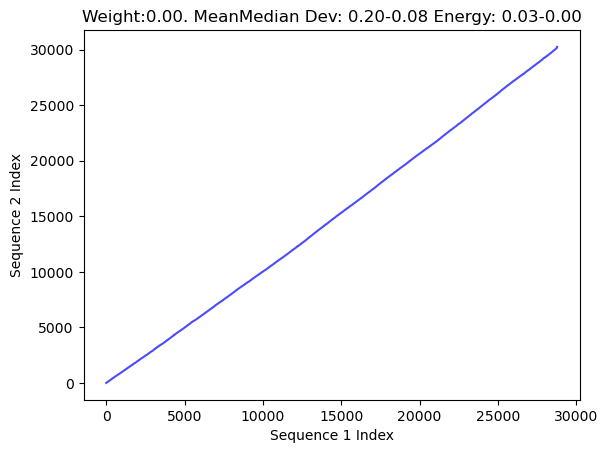

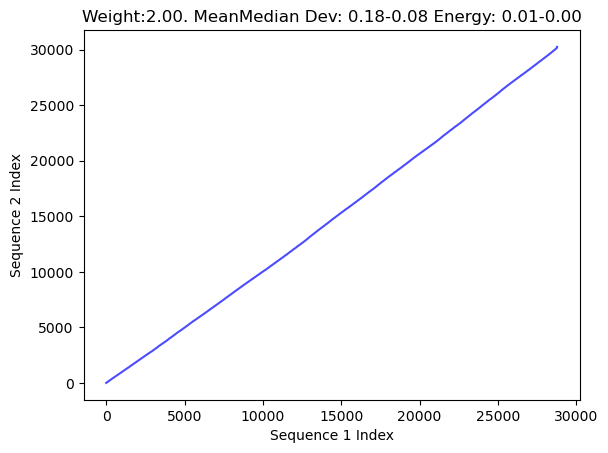

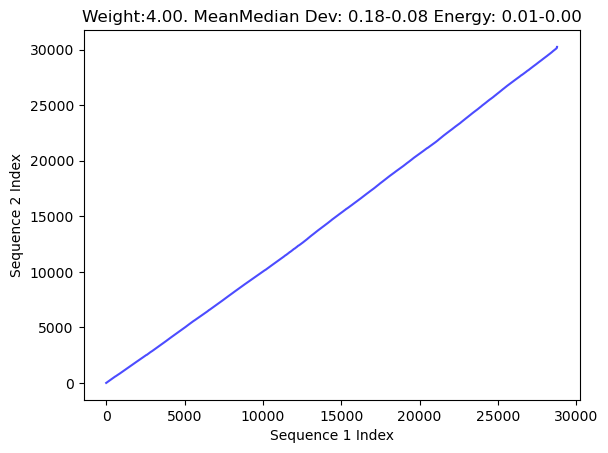

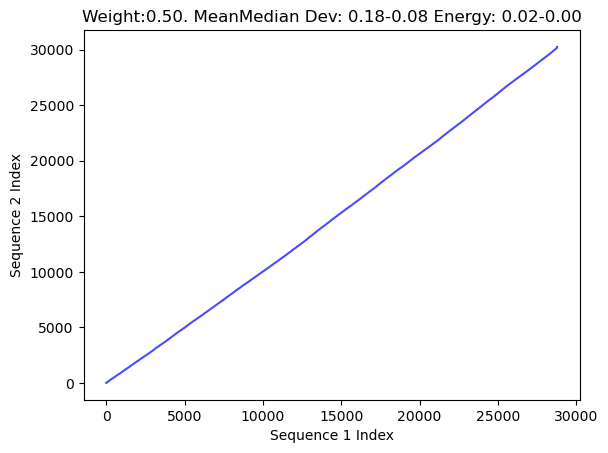

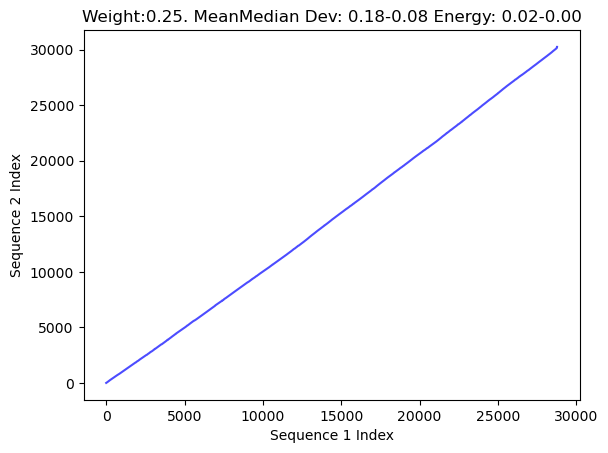

Analysing pair no. 10. Q 11 R 0.


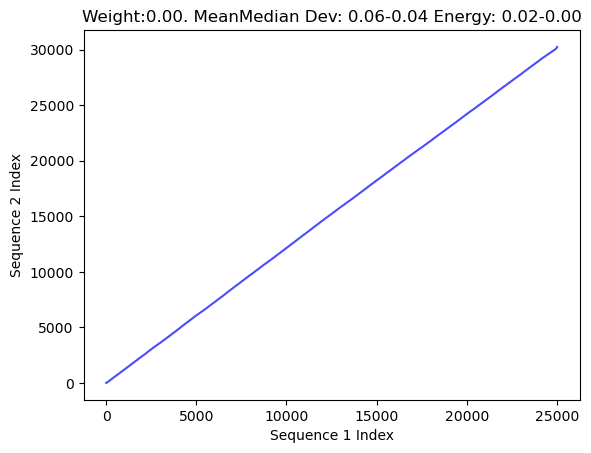

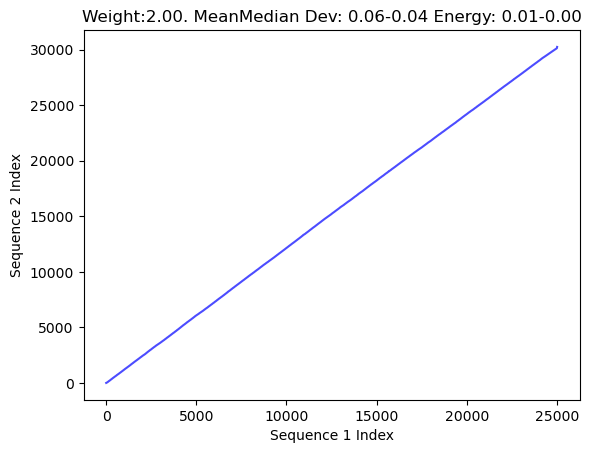

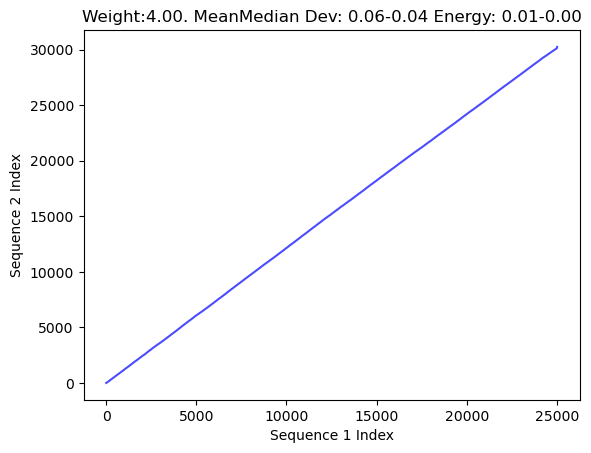

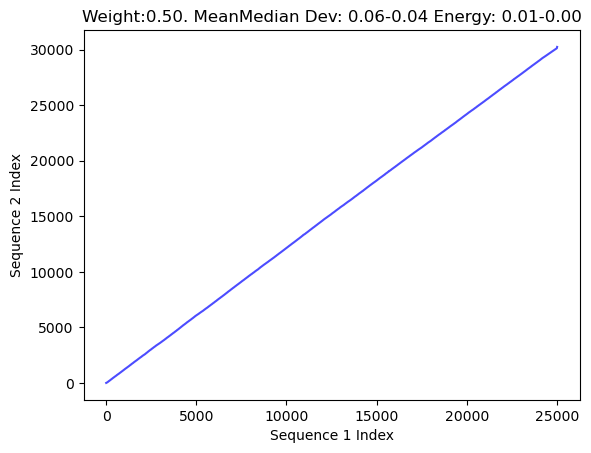

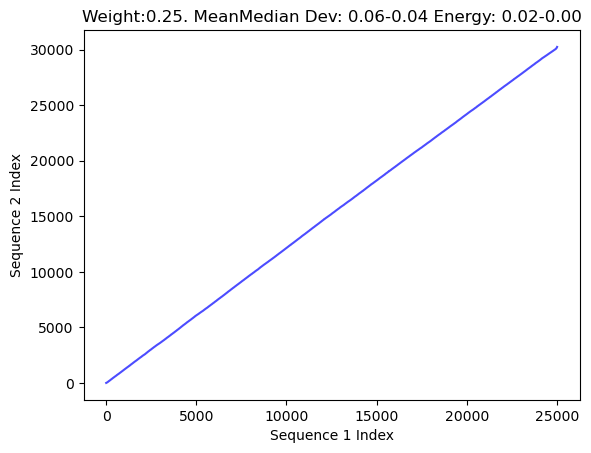

Analysing pair no. 39. Q 4 R 3.


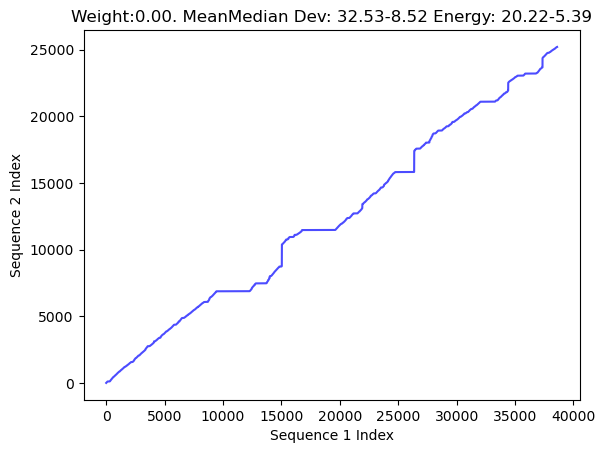

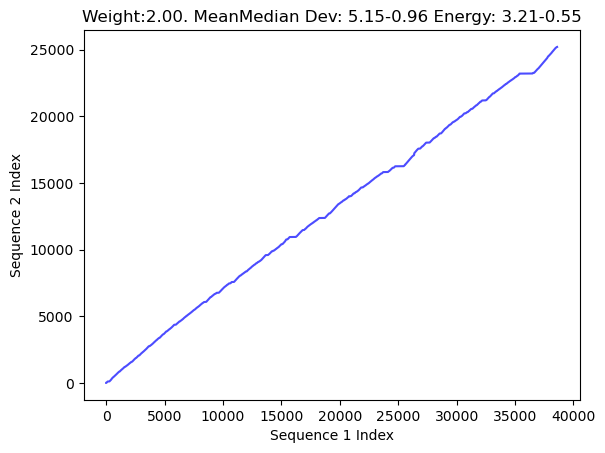

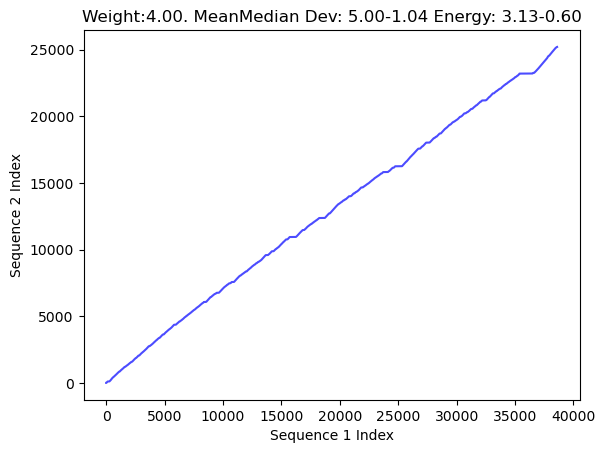

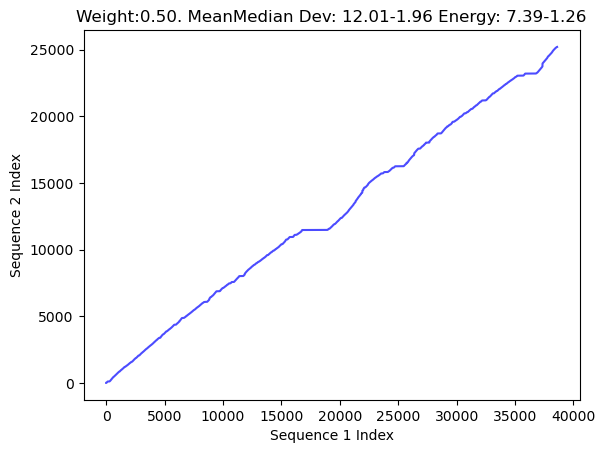

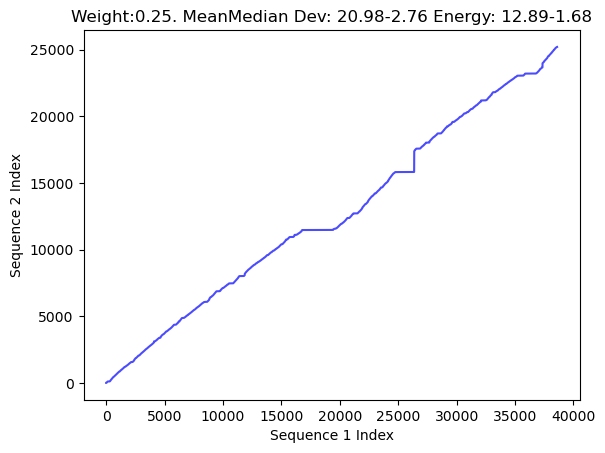

Analysing pair no. 32. Q 8 R 2.


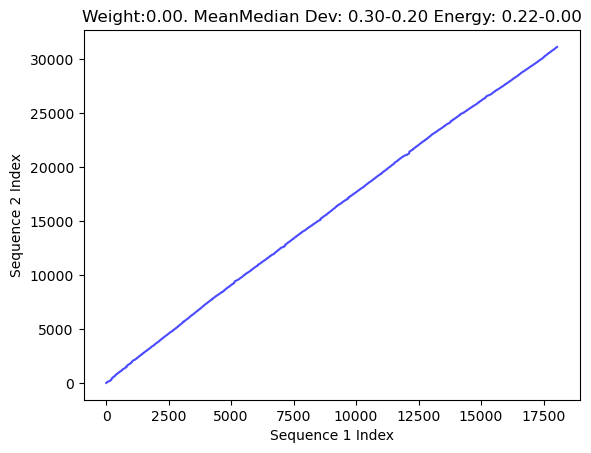

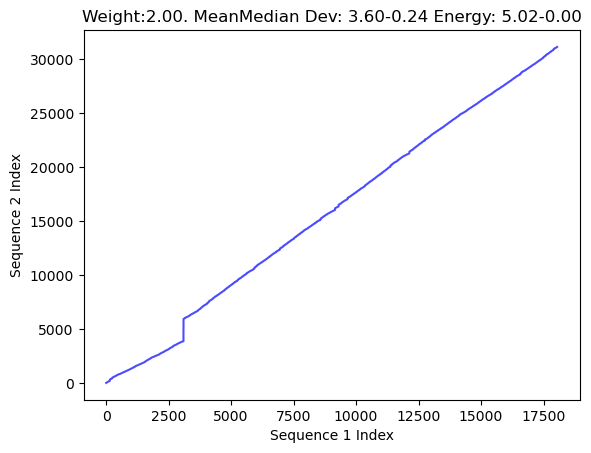

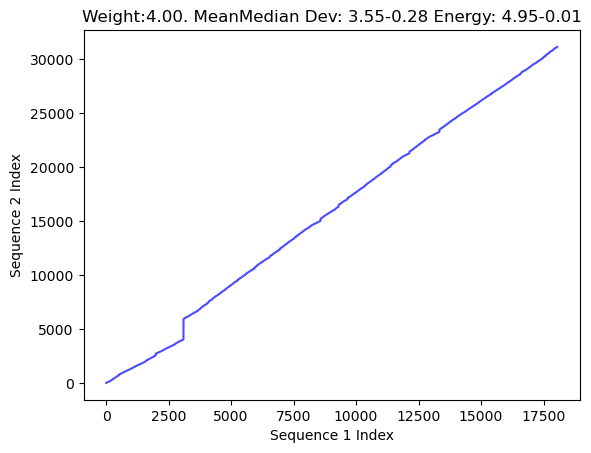

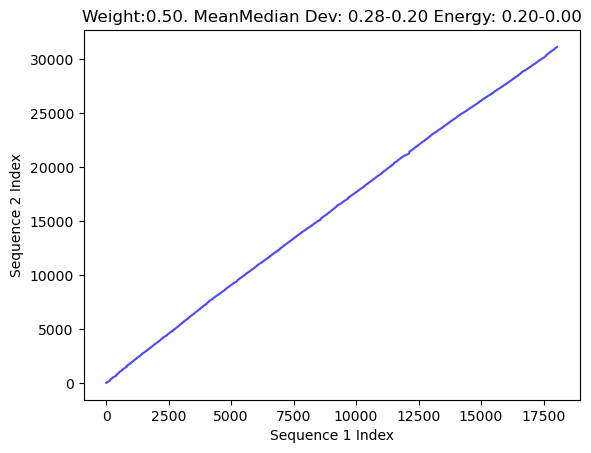

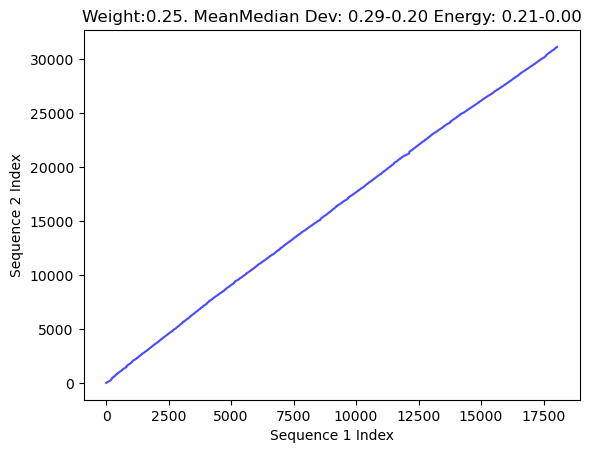

Analysing pair no. 53. Q 8 R 4.


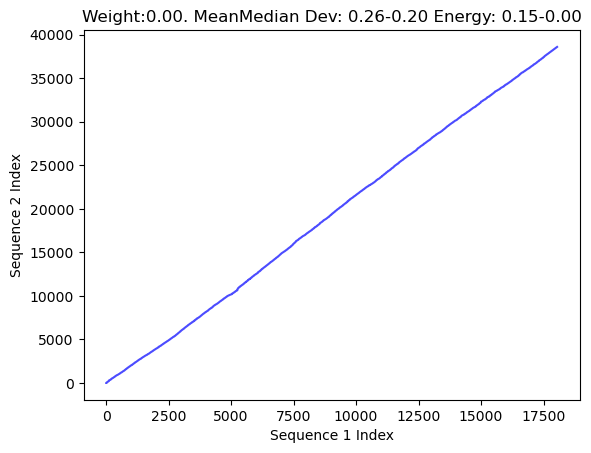

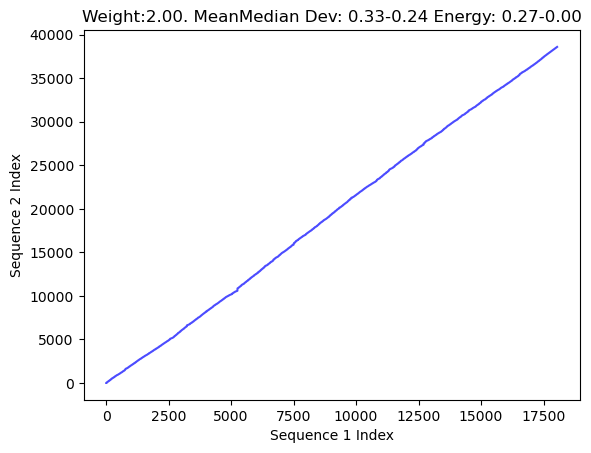

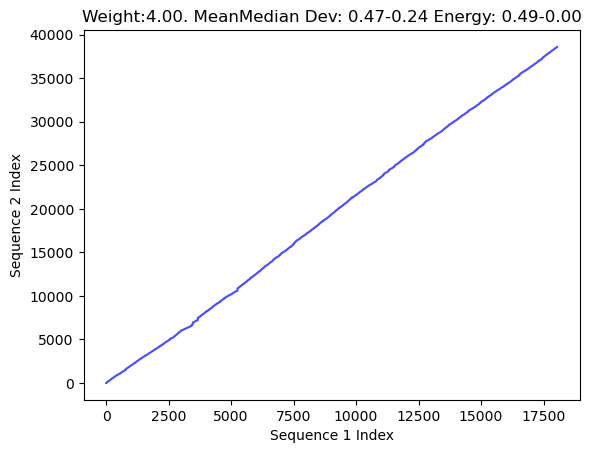

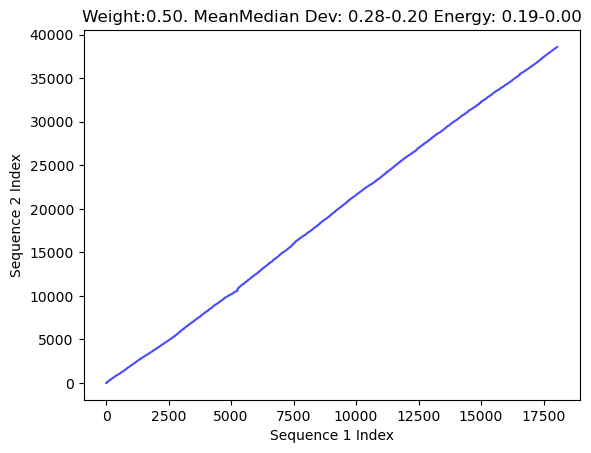

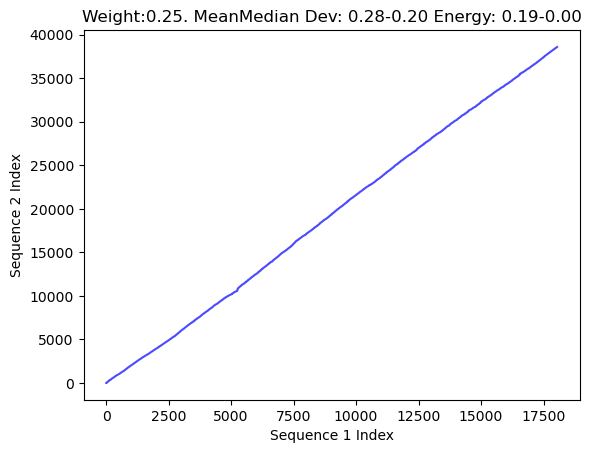

Analysing pair no. 62. Q 8 R 5.


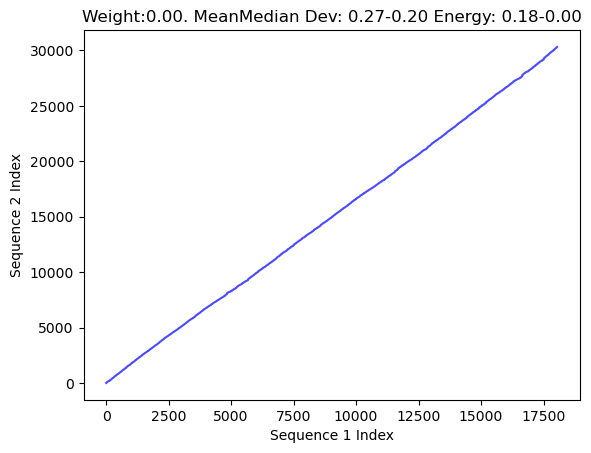

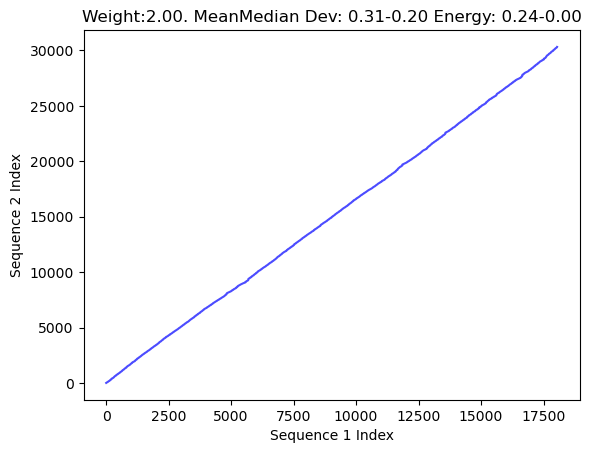

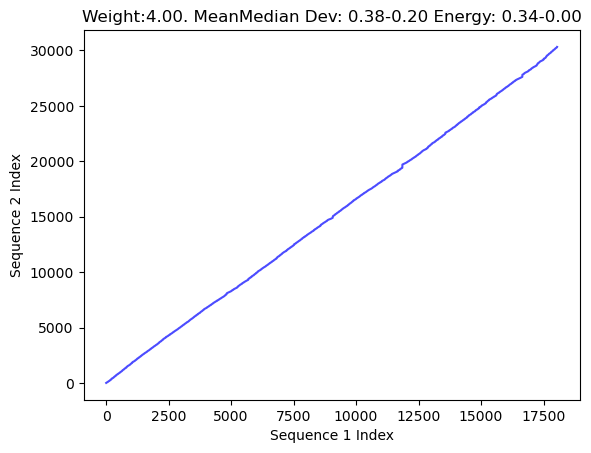

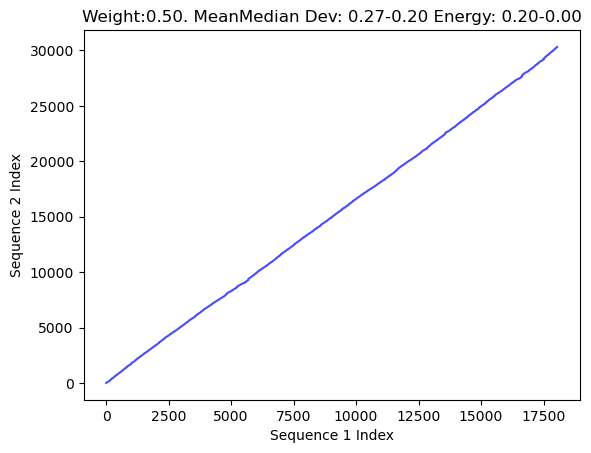

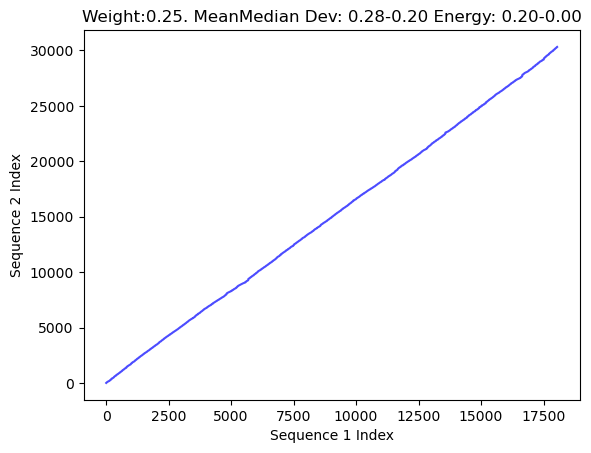

Analysing pair no. 70. Q 8 R 6.


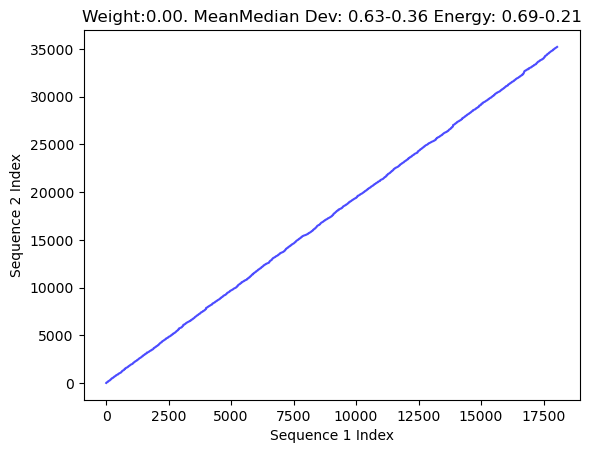

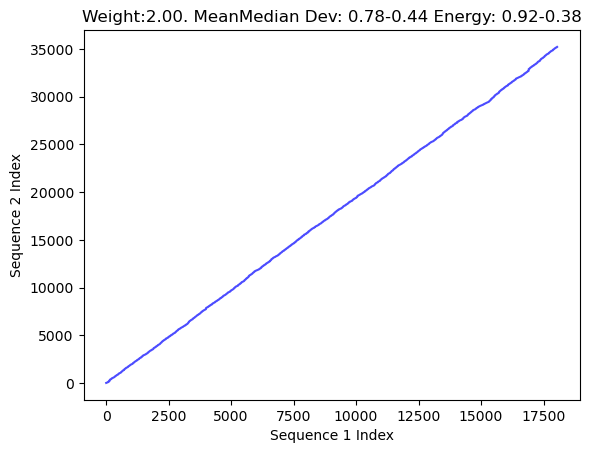

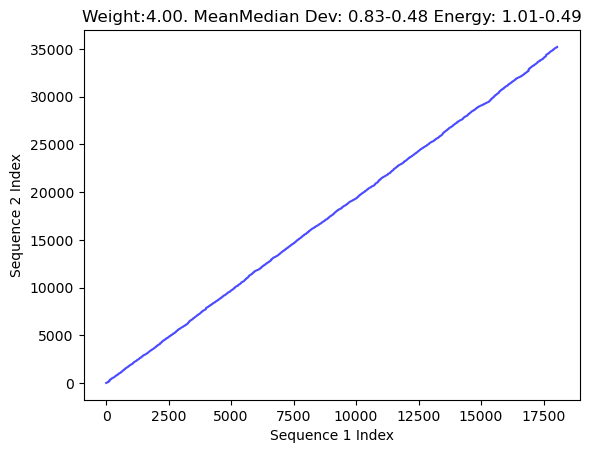

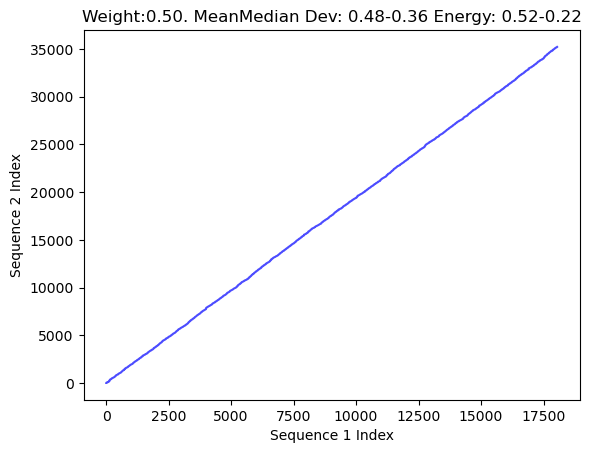

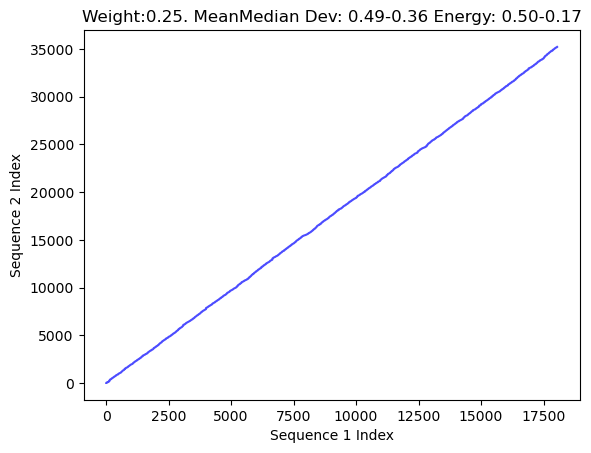

Analysing pair no. 100. Q 13 R 11.


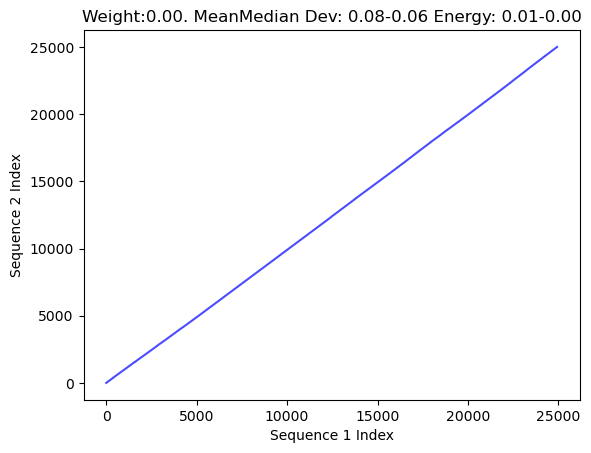

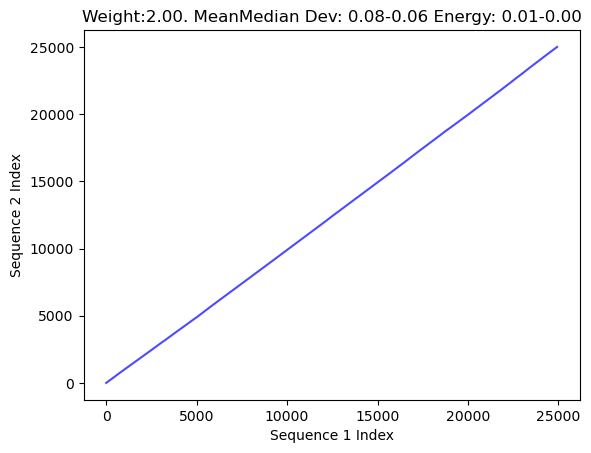

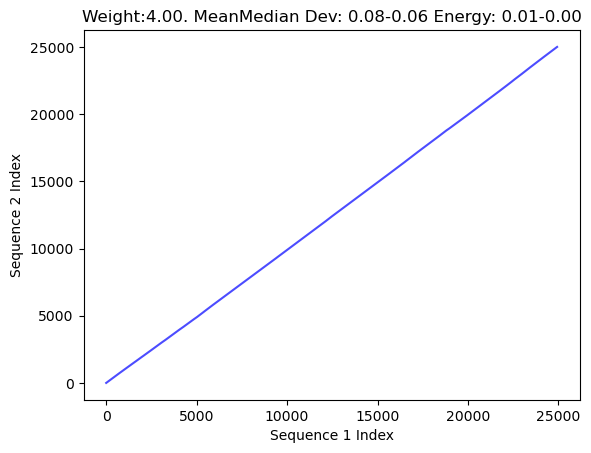

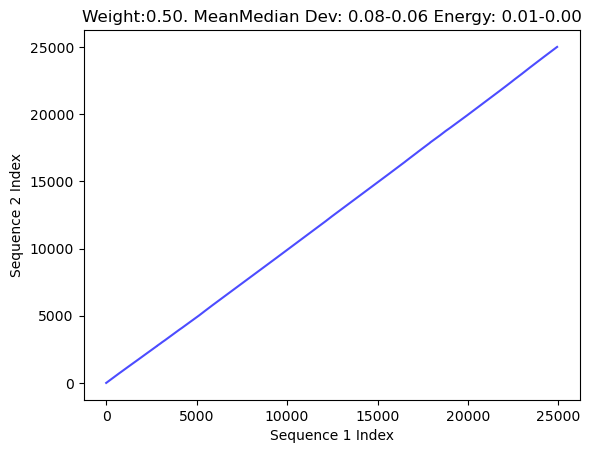

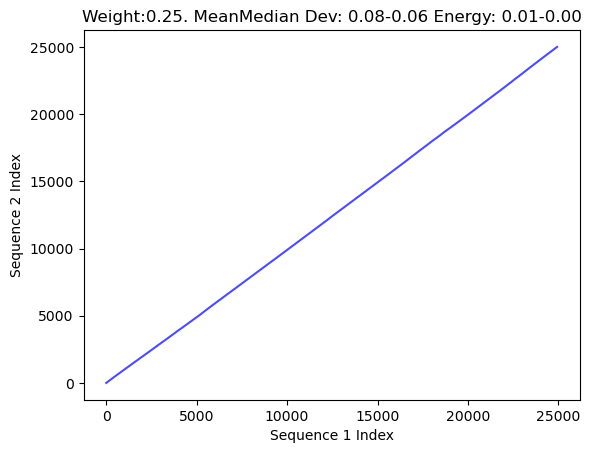

In [31]:

pair_nos = [0, 10, 39, 32, 53, 62, 70, 100]
weights = [0, 2, 4, 0.5, 0.25]

weights_results_array = numpy.zeros((len(weights), len(pair_nos), 4))

for i in range(len(pair_nos)):
    q_idx, r_idx = query_and_ref_from_pair_no(pair_nos[i], len(dataset_names))
    print("Analysing pair no. %d. Q %d R %d." %(pair_nos[i], q_idx, r_idx))
    ap = g_aeneas.alignment_pair(at_arr[q_idx], at_arr[r_idx], "cosine", -1)
    for j in range(len(weights)):
        if (j == 0):
            ap.set_warping_path("%s\%d_%d.bin" %(aeneas_path, q_idx, r_idx))
        else:
            ap.set_warping_path("%s\%d_%d_%d.bin" %(aeneas_weight_path, q_idx, r_idx, j))
        dev_mean, energy_mean, dev_median, energy_median = ap.get_alignment_deviation_normal()
        weights_results_array[j][i] = dev_mean, energy_mean, dev_median, energy_median
        plot_wp(ap.wp, "Weight:%.2f. MeanMedian Dev: %.2f-%.2f Energy: %.2f-%.2f" 
            %(weights[j], dev_mean, dev_median, energy_mean, energy_median))

Printing the values for each pair-weight combination.

cost matrix = cosine + (weight * euclidean)

cost matrix = cosine + (2 * euclidean) means 33% of cosine and 66% of euclidean.
cost matrix = cosine + (.5 * euclidean) means 66% of cosine and 33% of euclidean.

These two seem to offer the best performance, over these 8 pairs.


In [29]:

pair_nos = [0, 10, 39, 32, 53, 62, 70, 100]
weights = [0, 2, 4, 0.5, 0.25]

for i in range(len(pair_nos)):
    q_idx, r_idx = query_and_ref_from_pair_no(pair_nos[i], len(dataset_names))
    print("Analysing pair no. %d. Q %d R %d." %(pair_nos[i], q_idx, r_idx))
    ap = g_aeneas.alignment_pair(at_arr[q_idx], at_arr[r_idx], "cosine", -1)
    for j in range(len(weights)):
        if (j == 0):
            ap.set_warping_path("%s\%d_%d.bin" %(aeneas_path, q_idx, r_idx))
        else:
            ap.set_warping_path("%s\%d_%d_%d.bin" %(aeneas_weight_path, q_idx, r_idx, j))
        dev_mean, energy_mean, dev_median, energy_median = ap.get_alignment_deviation_normal()
        print("Weight:%.2f. MeanMedian Dev: %.2f-%.2f Energy: %.2f-%.2f" 
            %(weights[j], dev_mean, dev_median, energy_mean, energy_median))

Analysing pair no. 0. Q 1 R 0.
Weight:0.00. MeanMedian Dev: 0.20-0.08 Energy: 0.03-0.00
Weight:2.00. MeanMedian Dev: 0.18-0.08 Energy: 0.01-0.00
Weight:4.00. MeanMedian Dev: 0.18-0.08 Energy: 0.01-0.00
Weight:0.50. MeanMedian Dev: 0.18-0.08 Energy: 0.02-0.00
Weight:0.25. MeanMedian Dev: 0.18-0.08 Energy: 0.02-0.00
Analysing pair no. 10. Q 11 R 0.
Weight:0.00. MeanMedian Dev: 0.06-0.04 Energy: 0.02-0.00
Weight:2.00. MeanMedian Dev: 0.06-0.04 Energy: 0.01-0.00
Weight:4.00. MeanMedian Dev: 0.06-0.04 Energy: 0.01-0.00
Weight:0.50. MeanMedian Dev: 0.06-0.04 Energy: 0.01-0.00
Weight:0.25. MeanMedian Dev: 0.06-0.04 Energy: 0.02-0.00
Analysing pair no. 39. Q 4 R 3.
Weight:0.00. MeanMedian Dev: 32.53-8.52 Energy: 20.22-5.39
Weight:2.00. MeanMedian Dev: 5.15-0.96 Energy: 3.21-0.55
Weight:4.00. MeanMedian Dev: 5.00-1.04 Energy: 3.13-0.60
Weight:0.50. MeanMedian Dev: 12.01-1.96 Energy: 7.39-1.26
Weight:0.25. MeanMedian Dev: 20.98-2.76 Energy: 12.89-1.68
Analysing pair no. 32. Q 8 R 2.
Weight:0.00.

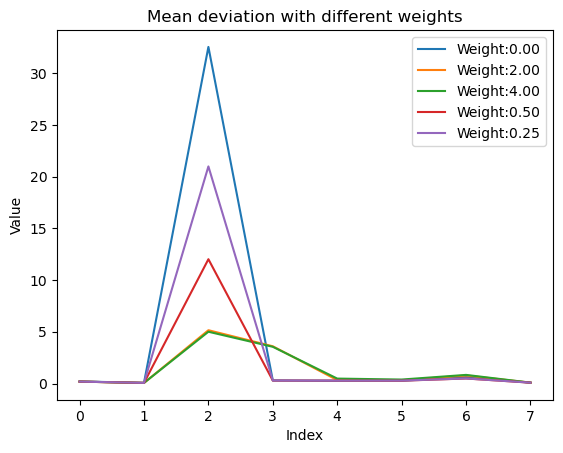

In [60]:
datas = []
labels = []
for i in range(len(weights)):
    datas.append(weights_results_array[i][:,0])
    labels.append("Weight:%.2f" %(weights[i]))
plot_multiple_arrays(datas, labels, "Mean deviation with different weights")

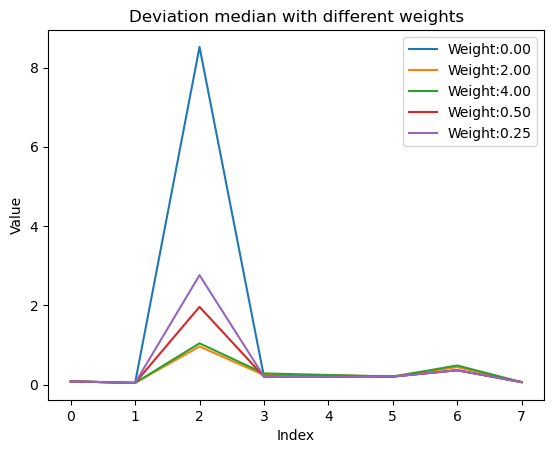

In [62]:
datas = []
labels = []
for i in range(len(weights)):
    datas.append(weights_results_array[i][:,2])
    labels.append("Weight:%.2f" %(weights[i]))
plot_multiple_arrays(datas, labels, "Deviation median with different weights")

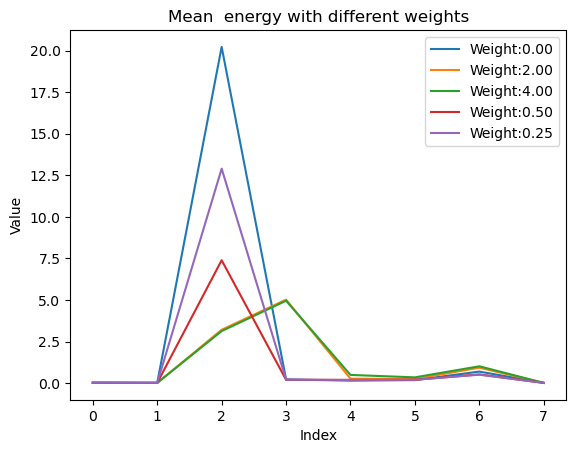

In [63]:
datas = []
labels = []
for i in range(len(weights)):
    datas.append(weights_results_array[i][:,1])
    labels.append("Weight:%.2f" %(weights[i]))
plot_multiple_arrays(datas, labels, "Mean  energy with different weights")

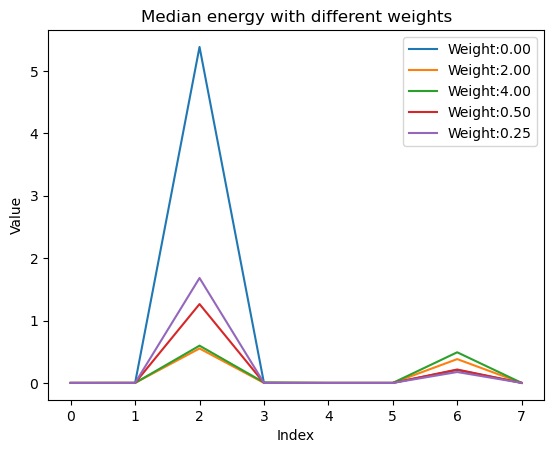

In [66]:
datas = []
labels = []
for i in range(len(weights)):
    datas.append(weights_results_array[i][:,3])
    labels.append("Weight:%.2f" %(weights[i]))
plot_multiple_arrays(datas, labels, "Median energy with different weights")